In [4]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())

True
NVIDIA GeForce RTX 3060 Laptop GPU
1


In [21]:
%matplotlib inline
import numpy as np
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.utils
from PIL import Image
import glob
import sys, os
sys.path.append(os.pardir) # 부모 디렉토리의 파일을 가져올 수 있도록 설정
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from collections import OrderedDict
import pickle
import torch
import cv2
from imutils.video import VideoStream
from pathlib import Path
import torch
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import torch.nn as nn
from PIL import Image
from torch.autograd import Variable
import PIL.ImageOps
from torch import optim
import torch.nn.functional as F
import random
import numpy as np
import torchvision.datasets as dataset

In [22]:
print(f"현재 디렉토리 위치: {os.getcwd()}")

현재 디렉토리 위치: c:\Users\yuddo\OneDrive\바탕 화면\temp\Personal_Project\3-1


In [23]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [24]:
# 해결 과제 : 순차적으로 들어가야하는 것 -> batch가 1이면 되는가?

class Config():
    training_dir = "C:/Users/yuddo/Yuchul/Project/Bowling/data/output/"
    #testing_dir = "./data/faces/testing/"
    train_batch_size = 1
    train_number_epochs = 100

In [25]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=False):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert #서로 다른 두 사람간의 볼링 자세 비교이기 때문에 invert는 False
        
    # 라벨링    
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [27]:
folder_dataset = dataset.ImageFolder(root=Config.training_dir)

In [36]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((1080,612)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

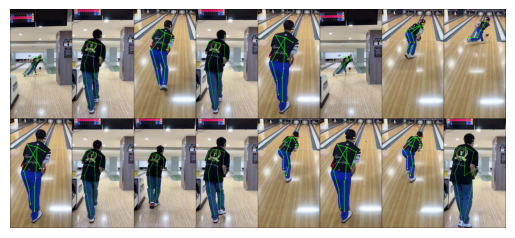

[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]


In [59]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=0,
                        batch_size=8)

dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

In [71]:
# 샴 네트워크 모델 정의
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),

            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 500),
            nn.ReLU(inplace=True),
            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2
        
#     def forward(self, input1, input2):
#         # 입력 이미지에 대한 처리 수행
#         # 각 이미지를 네트워크에 통과시킴
#         output1 = self.model(input1)
#         output2 = self.model(input2)
        
#         # 이미지 쌍의 유사성 계산
#         # 예를 들어, 유클리드 거리 계산 등
        
#         return similarity_score

# 동영상 데이터 처리
user_video_path = "C:/Users/yuddo/Yuchul/Project/Bowling/data/output/user.avi"
pro_video_path = "C:/Users/yuddo/Yuchul/Project/Bowling/data/output/pro.avi"
# 저장 폴더 경로 정의
user_output_folder = "C:/Users/yuddo/Yuchul/Project/Bowling/data/output/user_frame_img"
pro_output_folder = "C:/Users/yuddo/Yuchul/Project/Bowling/data/output/pro_frame_img"

In [69]:
class ContrastiveLoss(torch.nn.Module):

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
        (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [57]:
# 동영상을 프레임 단위로 분할
user_video_frames = split_video_into_frames(user_video_path, user_output_folder)

In [60]:
pro_video_frames = split_video_into_frames(pro_video_path, pro_output_folder)

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 폴더 경로 정의
folder = "C:/Users/yuddo/Yuchul/Project/Bowling/data/output"

# 이미지 폴더 데이터셋 정의
user_dataset = ImageFolder(folder, transform=ToTensor())
pro_dataset = ImageFolder(folder, transform=ToTensor())

# 데이터 로더 정의
user_loader = DataLoader(user_dataset, batch_size=2, shuffle=False)
pro_loader = DataLoader(pro_dataset, batch_size=1, shuffle=False)

# 모델 정의 및 불러오기
model = SiameseNetwork().to(device)

# 샴 네트워크에 이미지 프레임 적용
similarity_scores = []
for (image1, _), (image2, _) in zip(user_loader, pro_loader):
    image1 = image1.to(device)
    image2 = image2.to(device)
    
    output = model(image1, image2)
    similarity_scores.append(output.item())

# 결과 출력
for i, similarity_score in enumerate(similarity_scores):
    print(f"Frame {i+1}: Similarity Score = {similarity_score}")


AttributeError: 'SiameseNetwork' object has no attribute 'model'

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,Config.train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
show_plot(counter,loss_history)